In [21]:
import os
import time
from io import StringIO

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import keyfi as kf
from keyfi.dimred import UMAP
from keyfi.cluster import HDBSCAN

from sklearn.preprocessing import StandardScaler, MaxAbsScaler


params

In [22]:
DATA_PATH = "/home/azureuser/project/data/plane"
SNAPSHOT = "285140.078369"

#savepaths
figpath="/home/azureuser/project/figures/scaling_test"
embedding_path = os.path.join("/home/azureuser/project/data/embeddings/scaling_test", SNAPSHOT)

os.makedirs(figpath, exist_ok=True)
os.makedirs(embedding_path, exist_ok=True)

helper functions

In [23]:
def get_data(snapshot):
    return kf.import_vtk_data(
        os.path.join(DATA_PATH, snapshot, "data.vtk")
    )

data prep

In [24]:
df, mesh = get_data(SNAPSHOT)

df = pd.read_csv(StringIO(df.to_csv()), index_col=0)

cleaned_data = kf.clean_data(df, dim=2,
                             vars_to_drop=["N2", "NO2", "rho"]
                            )

features = [feature for feature in cleaned_data.columns[:-2]] + [["U:0", "U:1"]]
standard_scalers = ([StandardScaler] * len(cleaned_data.columns[:-2])) + [StandardScaler]
maxabs_scalers = ([MaxAbsScaler] * len(cleaned_data.columns[:-2])) + [MaxAbsScaler]

features

['T', 'N2O4', 'Qdot', ['U:0', 'U:1']]

UMAP params

In [25]:
n_neighbors_range = [200]
min_dist_range = [0.1]

scaling

In [26]:
cleaned_data100 = cleaned_data.copy()
cleaned_data100["Qdot"].clip(-100, 100, inplace=True)

cleaned_data200 = cleaned_data.copy()
cleaned_data200["Qdot"].clip(-200, 200, inplace=True)

In [27]:
standard100 = kf.scale_data(cleaned_data100, features, standard_scalers)
maxabs100 = kf.scale_data(cleaned_data100, features, maxabs_scalers)

standard200 = kf.scale_data(cleaned_data200, features, standard_scalers)
maxabs200 = kf.scale_data(cleaned_data200, features, maxabs_scalers)

dimred

In [28]:
saved_embeddings = os.listdir(embedding_path)

for n_neighbors in n_neighbors_range:
    for min_dist in min_dist_range:
        for data, scaling in zip((standard100, maxabs100, standard200, maxabs200), ("standard100", "maxabs100", "standard200", "maxabs200")):

            start_time = time.time()

            print(n_neighbors, min_dist, scaling)

            if f"{n_neighbors}_{min_dist}_{scaling}.npy" in saved_embeddings:
                embedding = np.load(
                    os.path.join(embedding_path, f"{n_neighbors}_{min_dist}_{scaling}.npy")
                    )
                print("loaded from existing")

            else:

                embedding, mapper = kf.embed_data(
                    data=data,
                    algorithm=UMAP,
                    n_neighbors=n_neighbors,
                    min_dist=min_dist,
                    #ensures reproducibility, disable for faster compute
                    # random_state=0,
                    #how many dimensions to reduce to
                    n_components=2,
                )

                np.save(
                    os.path.join(embedding_path, f"{n_neighbors}_{min_dist}_{scaling}"),
                    embedding
                )

            print("time:", time.time()-start_time)


200 0.1 standard100
time: 97.66128373146057
200 0.1 maxabs100
time: 97.14062404632568
200 0.1 standard200
time: 97.30392456054688
200 0.1 maxabs200
time: 97.01988244056702


make figures

/home/azureuser/project/keyfi/keyfi/plot.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


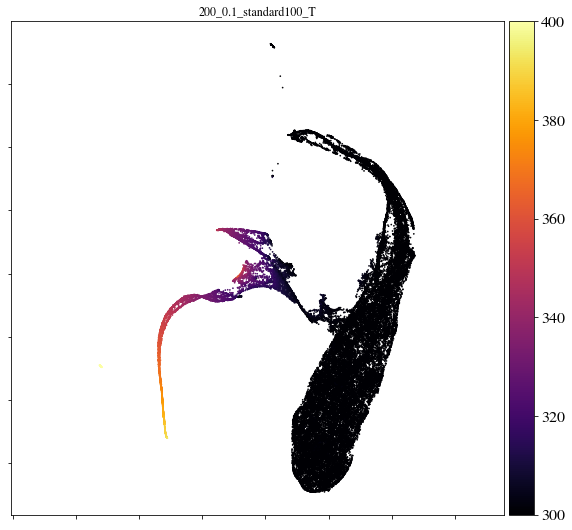

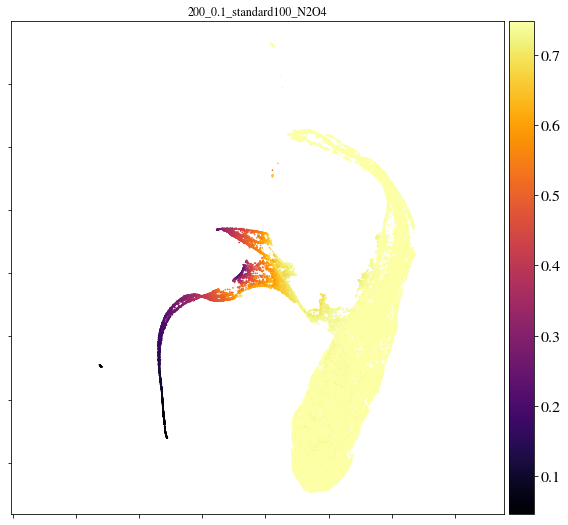

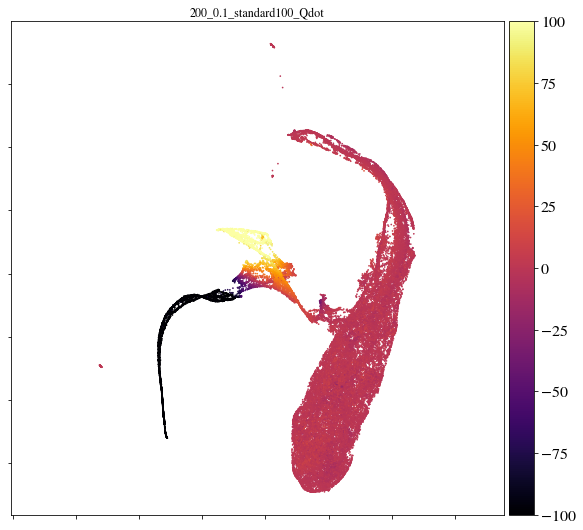

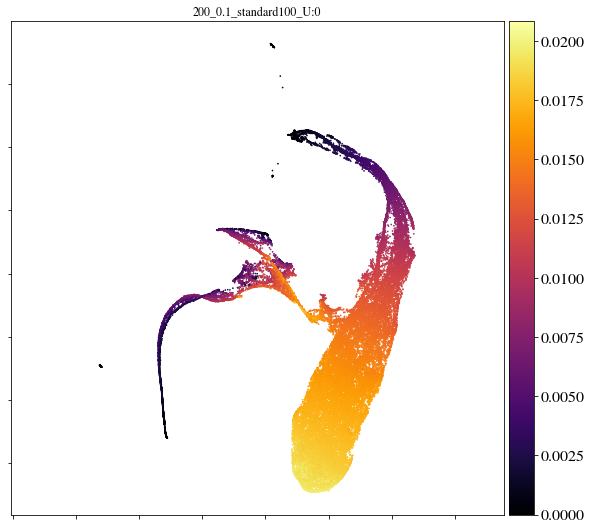

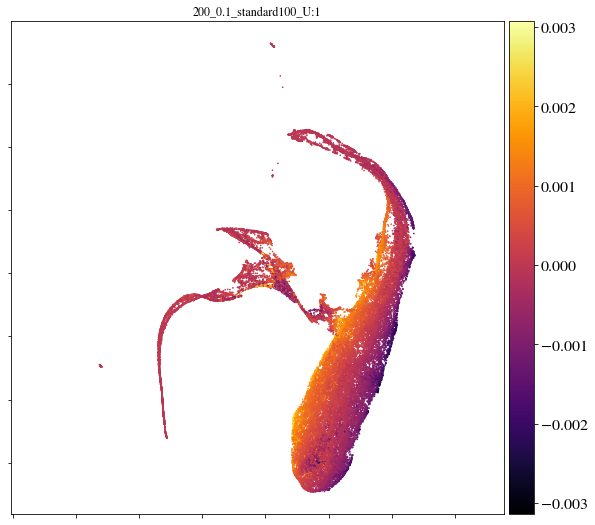

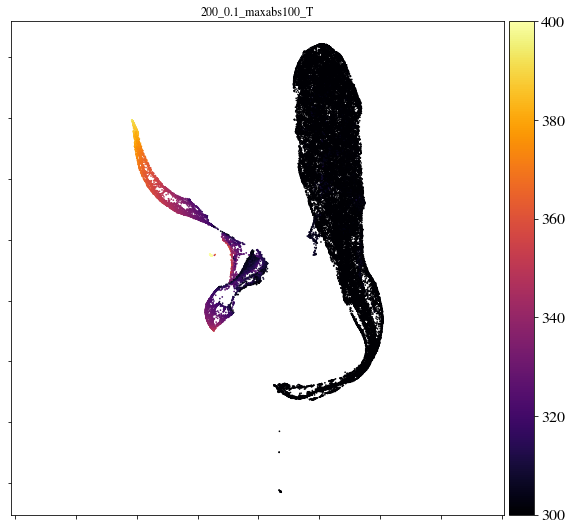

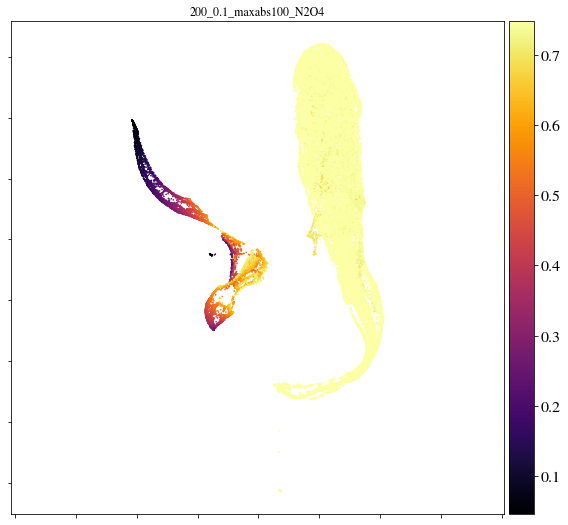

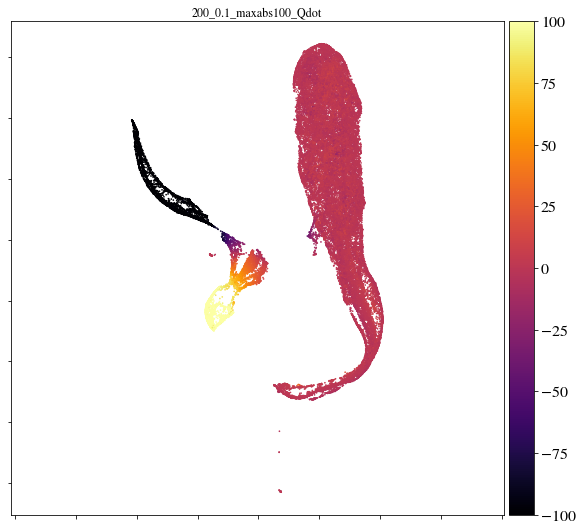

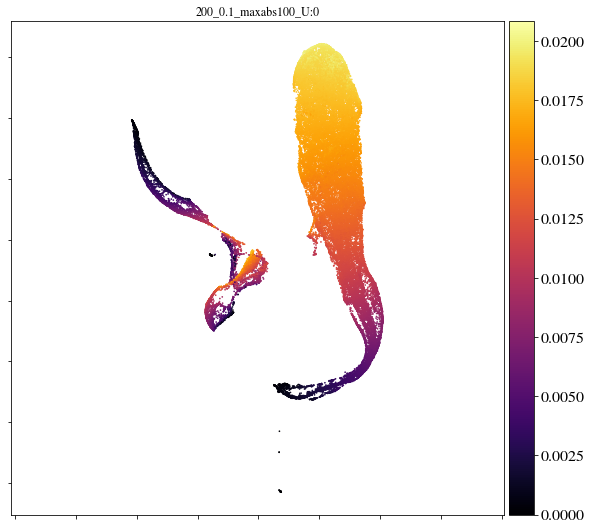

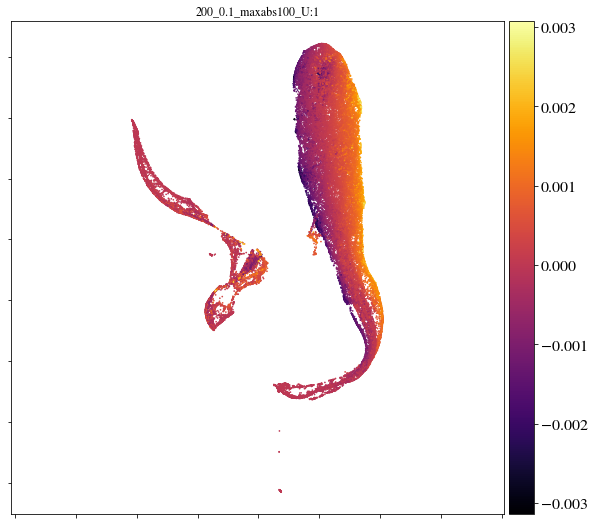

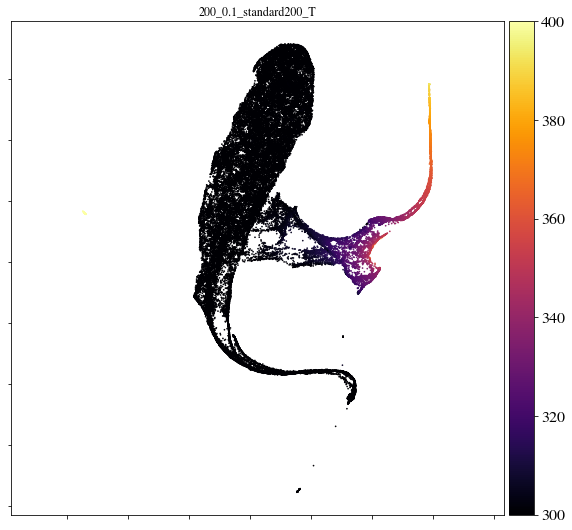

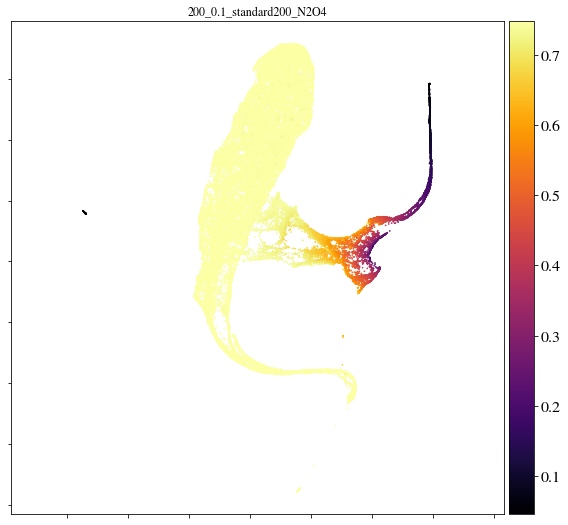

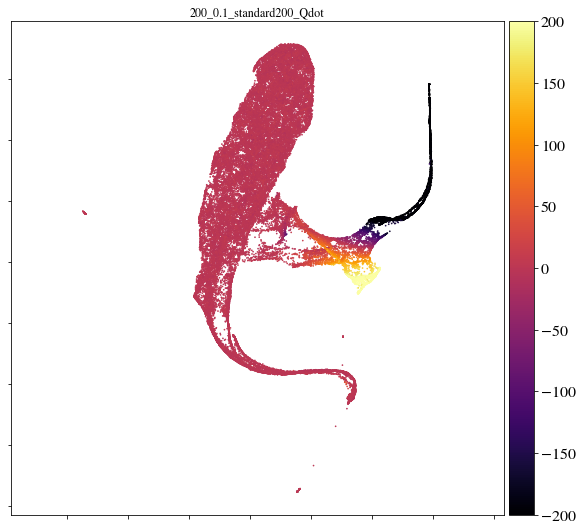

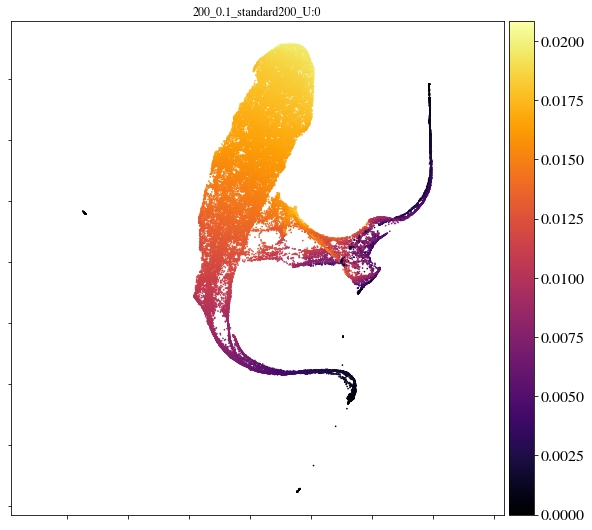

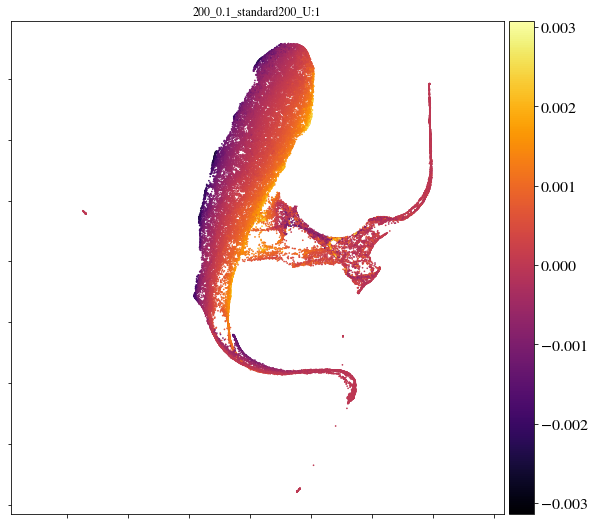

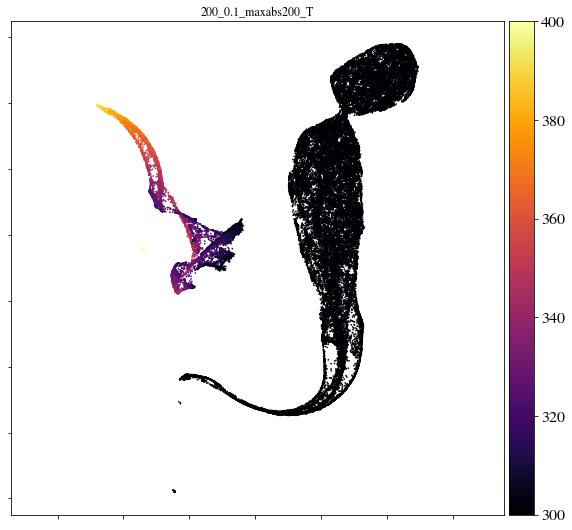

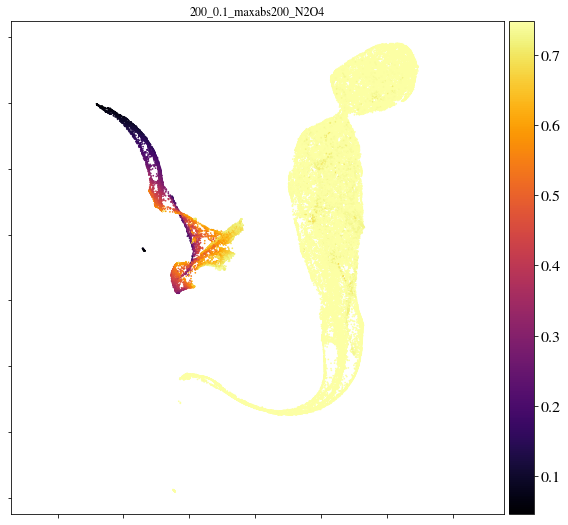

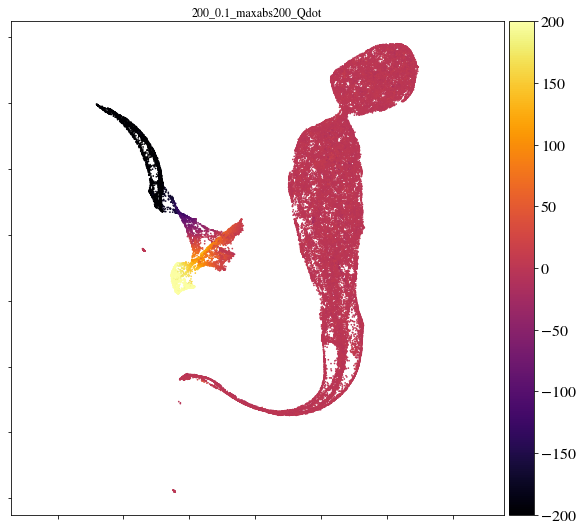

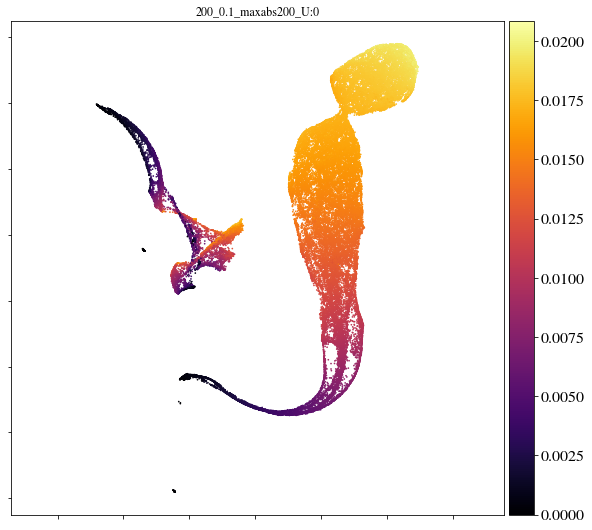

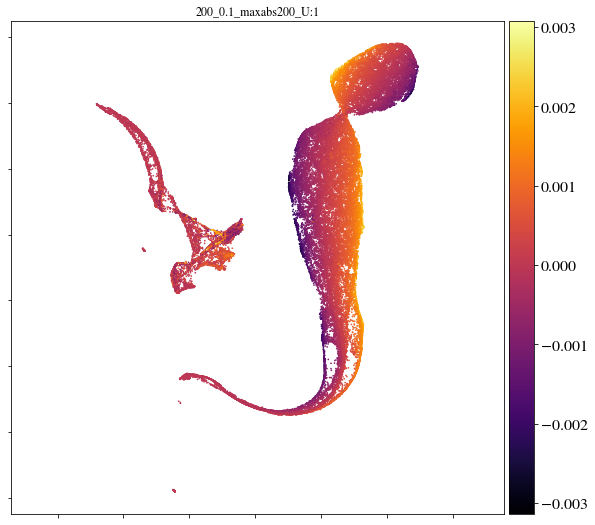

In [29]:
df, mesh = get_data(SNAPSHOT)

df = pd.read_csv(StringIO(df.to_csv()), index_col=0)

cleaned_data = kf.clean_data(df, dim=2,
                             vars_to_drop=["N2", "NO2", "rho"]
                            )

for n_neighbors in n_neighbors_range:
    for min_dist in min_dist_range:
        for scaling in ("standard100", "maxabs100", "standard200", "maxabs200"):
            
            embedding = np.load(
                os.path.join(embedding_path, f"{n_neighbors}_{min_dist}_{scaling}.npy")
                )
            
            for var in cleaned_data.columns:
            
                if var == "Qdot":
                    if "100" in scaling:
                        cmap_minmax=[-100, 100]
                    else:
                        cmap_minmax=[-200, 200]
                else:
                    cmap_minmax=[]

                kf.plot_embedding(
                    embedding=embedding,
                    data=cleaned_data,
                    scale_points = True,
                    cmap_var=var,
                    cmap_minmax=cmap_minmax,
                    save=True,
                    title=f"{n_neighbors}_{min_dist}_{scaling}_{var}",
                    figname=f"{n_neighbors}_{min_dist}_{scaling}_{var}",
                    figpath=figpath,
                    view=(None, None)
                )
                
            

OLD dimensionality reduction

In [ ]:
print("Starting embedding")
saved_embeddings = os.listdir(embedding_path)

for n_neighbors in n_neighbors_range:
    for min_dist in min_dist_range:

        start_time = time.time()

        print(n_neighbors, min_dist)

        if f"{n_neighbors}_{min_dist}.npy" in saved_embeddings:
            embedding = np.load(
                os.path.join(embedding_path, f"{n_neighbors}_{min_dist}.npy")
                )
            print("loaded from existing")

        else:

            embedding, mapper = kf.embed_data(
                data=cleaned_data,
                algorithm=UMAP
                n_neighbors=n_neighbors,
                min_dist=min_dist,
                #ensures reproducibility, disable for faster compute
                # random_state=0,
                #how many dimensions to reduce to
                n_components=2,
            )

            np.save(
                os.path.join(embedding_path, f"{n_neighbors}_{min_dist}"),
                embedding
            )
            
        print("time:", time.time()-start_time)

Starting embedding
50 0.05
loaded from existing
time: 0.0013496875762939453
50 0.1
loaded from existing
time: 0.0011224746704101562
50 0.15
loaded from existing
time: 0.0007863044738769531
100 0.05
loaded from existing
time: 0.0006401538848876953
100 0.1
loaded from existing
time: 0.000640869140625
100 0.15
loaded from existing
time: 0.0009827613830566406
150 0.05
loaded from existing
time: 0.0010030269622802734
150 0.1
loaded from existing
time: 0.0009617805480957031
150 0.15
loaded from existing
time: 0.0009753704071044922
200 0.05
time: 118.36742925643921
200 0.1
time: 103.94423866271973
200 0.15


OLD figure creation BORKED?

In [ ]:
for n_neighbors in n_neighbors_range:
    for min_dist in min_dist_range:

        print(n_neighbors, min_dist)

        for var in variables:

            if var == "Qdot":
                cmap_minmax=(-300, 300)
            else:
                cmap_minmax=[]

            kf.plot_embedding(
                embedding=embedding,
                data=cleaned_data,
                scale_points = True,
                cmap_var=var,
                cmap_minmax=cmap_minmax,
                save=True,
                title=f"{n_neighbors}_{min_dist}_{var}",
                figname=f"{n_neighbors}_{min_dist}_{var}",
                figpath=figpath,
                view=(None, None)
            )

50 0.05
50 0.1
50 0.15
